In [ ]:
#@title Default title text
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(name=fn, length=len(uploaded[fn])))

In [29]:
import pandas as pd
import numpy as np

def to_month_id(year, month):
  return (year - 1996) * 12 + month - 6

n_features = 12
lookback = 3
chosen_stocks = ["ADBE"] # "AMZN", "MSFT", "IBM", "INTC", "QCOM", "NVDA", "IBM", "ADBE", "EBAY", "CSCO"

In [30]:
dfFeature = pd.read_csv("./lstm_2004_12.csv")
# dfFeature.loc[dfFeature["return"] == 0, "return"] = 1
dfFeature = dfFeature[dfFeature.QAId.isin(chosen_stocks)]
features = dfFeature.drop(columns=['month_id', 'QAId']).as_matrix()
print(features.shape)

(157, 12)


In [31]:
from sklearn.preprocessing import MinMaxScaler
normalizedFeatures = MinMaxScaler().fit_transform(features) \
                                   .reshape(157, len(chosen_stocks), n_features) \
                                   .reshape(157, len(chosen_stocks) * n_features)
print(normalizedFeatures.shape)

(157, 12)


In [32]:
dfTarget = pd.read_csv("./return_2004_40.csv")
dfTarget["return"] = np.sign(dfTarget["return"])
# dfTarget.loc[dfTarget["return"] == 0, "return"] = 1
dfTarget = dfTarget[dfTarget.QAId.isin(chosen_stocks)]
dfTarget = dfTarget[dfTarget.month_id >= (to_month_id(2004, 1) + lookback)]
targets = MinMaxScaler().fit_transform(dfTarget.drop(columns=['month_id', 'QAId']).as_matrix())
y = targets.reshape(157 - lookback + 1, len(chosen_stocks))
print(y.shape)

(155, 1)


In [33]:
from keras.preprocessing.sequence import TimeseriesGenerator

splittedFeature = normalizedFeatures
print(splittedFeature.shape)

(157, 12)


In [34]:
from keras.preprocessing.sequence import TimeseriesGenerator

x = np.zeros((157 - lookback + 1, lookback, n_features * len(chosen_stocks)))
y_mock = np.zeros((157, len(chosen_stocks)))

i = 0
for train, test in TimeseriesGenerator(splittedFeature, y_mock, length=lookback, batch_size=1):
  if i > 157 - lookback:
    break
  x[i] = train[0]
  i = i + 1

In [35]:
from sklearn.model_selection import PredefinedSplit

test_months = 26
end_point = 157 - lookback + 1
split_point = 157 - lookback + 1 - test_months

x_train = x[0:split_point - 48].reshape(split_point - 48, lookback, n_features * len(chosen_stocks))
y_train = y[0:split_point - 48].reshape(split_point - 48, len(chosen_stocks))
x_validate = x[split_point - 36:split_point].reshape(36, lookback, n_features * len(chosen_stocks))
y_validate = y[split_point - 36:split_point].reshape(36, len(chosen_stocks))
x_test = x[split_point:end_point].reshape(test_months, lookback, n_features * len(chosen_stocks))
y_test = y[split_point:end_point].reshape(test_months, len(chosen_stocks))

print(x_train.shape)
print(y_train.shape)
print(x_validate.shape)
print(y_validate.shape)
print(x_test.shape)
print(y_test.shape)

# ps = PredefinedSplit(np.append(np.negative(np.ones(60 * 465)), np.zeros(24 * 465))).split(x_train)

# for train_ids, test_ids in ps:
#   print(str(train_ids) + ", " + str(test_ids))

(81, 3, 12)
(81, 1)
(36, 3, 12)
(36, 1)
(26, 3, 12)
(26, 1)


In [50]:
from sklearn.model_selection import PredefinedSplit, GridSearchCV
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, LSTM, Flatten, CuDNNLSTM
from keras.regularizers import l1_l2, l2
from keras.optimizers import RMSprop, Adam
from keras.wrappers.scikit_learn import KerasClassifier, KerasRegressor

np.random.seed(4103)

def create_model(*param):
    model = Sequential()
    model.add(LSTM(units=128, input_shape=(lookback, n_features * len(chosen_stocks)), return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=64, return_sequences=True))
    model.add(Dropout(0.1))
    model.add(LSTM(units=64, return_sequences=False))
    model.add(Dropout(0.1))
    model.add(Dense(64, activation="relu"))
    model.add(Dense(32, activation="relu"))
    model.add(Dense(len(chosen_stocks), activation="relu"))
    model.compile(loss='binary_crossentropy', optimizer=Adam(lr=0.0001, decay=0.0), metrics=['accuracy'], *param)
    return model

In [51]:
batch_size=30

model = create_model()
train_score = model.fit(x_train, y_train, validation_data=(x_validate, y_validate), batch_size=batch_size, epochs=200)
print(train_score)

Train on 81 samples, validate on 36 samples
Epoch 1/200
81/81 [==============================] - 3s 36ms/step - loss: 7.8722 - acc: 0.3827 - val_loss: 3.4019 - val_acc: 0.3333
Epoch 2/200
81/81 [==============================] - 0s 553us/step - loss: 3.8124 - acc: 0.3827 - val_loss: 3.0420 - val_acc: 0.3333
Epoch 3/200
81/81 [==============================] - 0s 523us/step - loss: 2.9642 - acc: 0.3827 - val_loss: 2.8515 - val_acc: 0.3333
Epoch 4/200
81/81 [==============================] - 0s 531us/step - loss: 2.6759 - acc: 0.3827 - val_loss: 2.7053 - val_acc: 0.3333
Epoch 5/200
81/81 [==============================] - 0s 535us/step - loss: 2.5205 - acc: 0.3827 - val_loss: 2.5894 - val_acc: 0.3333
Epoch 6/200
81/81 [==============================] - 0s 527us/step - loss: 2.4227 - acc: 0.3827 - val_loss: 2.4953 - val_acc: 0.3333
Epoch 7/200
81/81 [==============================] - 0s 497us/step - loss: 2.3229 - acc: 0.3827 - val_loss: 2.4161 - val_acc: 0.3333
Epoch 8/200
81/81 [=======

Epoch 62/200
81/81 [==============================] - 0s 481us/step - loss: 0.8959 - acc: 0.3827 - val_loss: 0.9360 - val_acc: 0.3333
Epoch 63/200
81/81 [==============================] - 0s 509us/step - loss: 0.8854 - acc: 0.3827 - val_loss: 0.9176 - val_acc: 0.3333
Epoch 64/200
81/81 [==============================] - 0s 471us/step - loss: 0.8841 - acc: 0.3827 - val_loss: 0.8996 - val_acc: 0.3333
Epoch 65/200
81/81 [==============================] - 0s 494us/step - loss: 0.8583 - acc: 0.3827 - val_loss: 0.8823 - val_acc: 0.3333
Epoch 66/200
81/81 [==============================] - 0s 480us/step - loss: 0.8373 - acc: 0.3827 - val_loss: 0.8654 - val_acc: 0.3333
Epoch 67/200
81/81 [==============================] - 0s 500us/step - loss: 0.8290 - acc: 0.3827 - val_loss: 0.8490 - val_acc: 0.3333
Epoch 68/200
81/81 [==============================] - 0s 495us/step - loss: 0.8062 - acc: 0.3827 - val_loss: 0.8332 - val_acc: 0.3333
Epoch 69/200
81/81 [==============================] - 0s 509us

Epoch 123/200
81/81 [==============================] - 0s 468us/step - loss: 0.6677 - acc: 0.6420 - val_loss: 0.6447 - val_acc: 0.6667
Epoch 124/200
81/81 [==============================] - 0s 499us/step - loss: 0.6653 - acc: 0.6173 - val_loss: 0.6451 - val_acc: 0.6389
Epoch 125/200
81/81 [==============================] - 0s 494us/step - loss: 0.6481 - acc: 0.6296 - val_loss: 0.6458 - val_acc: 0.6389
Epoch 126/200
81/81 [==============================] - 0s 507us/step - loss: 0.6713 - acc: 0.6296 - val_loss: 0.6464 - val_acc: 0.6389
Epoch 127/200
81/81 [==============================] - 0s 511us/step - loss: 0.6821 - acc: 0.5802 - val_loss: 0.6468 - val_acc: 0.6389
Epoch 128/200
81/81 [==============================] - 0s 519us/step - loss: 0.6771 - acc: 0.5926 - val_loss: 0.6471 - val_acc: 0.6389
Epoch 129/200
81/81 [==============================] - 0s 502us/step - loss: 0.6620 - acc: 0.6173 - val_loss: 0.6472 - val_acc: 0.6389
Epoch 130/200
81/81 [==============================] - 

Epoch 184/200
81/81 [==============================] - 0s 464us/step - loss: 0.6661 - acc: 0.6173 - val_loss: 0.6503 - val_acc: 0.6111
Epoch 185/200
81/81 [==============================] - 0s 503us/step - loss: 0.6749 - acc: 0.5926 - val_loss: 0.6508 - val_acc: 0.6111
Epoch 186/200
81/81 [==============================] - 0s 472us/step - loss: 0.6583 - acc: 0.6049 - val_loss: 0.6520 - val_acc: 0.5833
Epoch 187/200
81/81 [==============================] - 0s 500us/step - loss: 0.6671 - acc: 0.5926 - val_loss: 0.6524 - val_acc: 0.5833
Epoch 188/200
81/81 [==============================] - 0s 513us/step - loss: 0.6448 - acc: 0.6296 - val_loss: 0.6517 - val_acc: 0.5833
Epoch 189/200
81/81 [==============================] - 0s 481us/step - loss: 0.6655 - acc: 0.5926 - val_loss: 0.6514 - val_acc: 0.5833
Epoch 190/200
81/81 [==============================] - 0s 497us/step - loss: 0.6407 - acc: 0.6420 - val_loss: 0.6505 - val_acc: 0.6111
Epoch 191/200
81/81 [==============================] - 

26/26 [==============================] - 0s 155us/step
loss: 0.6992578506469727
acc: 0.3461538553237915


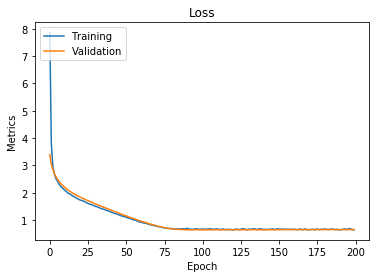

In [52]:
import matplotlib.pyplot as plt

test_score = model.evaluate(x_test, y_test, batch_size=batch_size)
for i, mn in enumerate(model.metrics_names):
  print(mn + ": " + str(test_score[i]))

plt.plot(train_score.history["loss"])
plt.plot(train_score.history["val_loss"])
plt.title("Loss")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend(["Training", "Validation"], loc="upper left")
plt.show()

In [53]:
from sklearn.metrics import precision_score, recall_score, classification_report

def threshold_tester(result, target, a, b):
  for t in np.arange(a, b + 0.05, 0.05):
    print("thresholder: " + str(t))
    print(classification_report(target, (result >= t).astype(int)))

In [54]:
result = model.predict(x_test, batch_size=batch_size)
print(result)
threshold_tester(result, y_test, 0.1, 0.9)

[[0.5186666 ]
 [0.50272137]
 [0.49509692]
 [0.50783515]
 [0.49503946]
 [0.49134734]
 [0.50436056]
 [0.47616613]
 [0.46926677]
 [0.48115957]
 [0.49921754]
 [0.47565764]
 [0.49731094]
 [0.47529972]
 [0.43182454]
 [0.46100533]
 [0.50745785]
 [0.52050674]
 [0.5243592 ]
 [0.5046872 ]
 [0.5344757 ]
 [0.5241608 ]
 [0.5058798 ]
 [0.4679069 ]
 [0.4805373 ]
 [0.71058255]]
thresholder: 0.1
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         7
        1.0       0.73      1.00      0.84        19

avg / total       0.53      0.73      0.62        26

thresholder: 0.15000000000000002
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         7
        1.0       0.73      1.00      0.84        19

avg / total       0.53      0.73      0.62        26

thresholder: 0.20000000000000004
             precision    recall  f1-score   support

        0.0       0.00      0.00      0.00         7
        1.0    

/Users/billykwok/.pyenv/versions/anaconda3-5.1.0/lib/python3.6/site-packages/sklearn/metrics/classification.py:1135: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


In [55]:
import math

buy_list = []
sell_list = []
def second_largest(numbers):
    count = 0
    m1 = m2 = float('-inf')
    for x in numbers:
        count += 1
        if x > m2:
            if x >= m1:
                m1, m2 = x, m1            
            else:
                m2 = x
    return m2 if count >= 2 else None

midpt = (second_largest(map(lambda x: x[0], result)) + min(map(lambda x: x[0], result))) / 2

for i, r in enumerate(result):
  buy_or_sell = 1 if r.item() > midpt * 1.05 else (-1 if r.item() < midpt * 0.95 else 0)
  if r.item() > midpt * 1.05:
    buy_list.append({'month_id': i + 223, 'QAId': chosen_stocks[0]})
  if r.item() < midpt * 0.95:
    sell_list.append({'month_id': i + 223, 'QAId': chosen_stocks[0]})
  print(str(y_test[i].item()) + ": " + str(buy_or_sell))
  if (math.fabs(buy_or_sell - y_test[i].item()) == 2) or (buy_or_sell - y_test[i].item() == 1):
    print("Hey")
print(buy_list)
print(sell_list)

1.0: 1
0.0: 0
1.0: 0
1.0: 1
1.0: 0
1.0: 0
0.0: 0
1.0: 0
1.0: 0
1.0: 0
1.0: 0
0.0: 0
0.0: 0
1.0: 0
1.0: -1
Hey
1.0: 0
0.0: 1
Hey
1.0: 1
1.0: 1
1.0: 0
0.0: 1
Hey
0.0: 1
Hey
1.0: 0
1.0: 0
1.0: 0
1.0: 1
[{'month_id': 223, 'QAId': 'ADBE'}, {'month_id': 226, 'QAId': 'ADBE'}, {'month_id': 239, 'QAId': 'ADBE'}, {'month_id': 240, 'QAId': 'ADBE'}, {'month_id': 241, 'QAId': 'ADBE'}, {'month_id': 243, 'QAId': 'ADBE'}, {'month_id': 244, 'QAId': 'ADBE'}, {'month_id': 248, 'QAId': 'ADBE'}]
[{'month_id': 237, 'QAId': 'ADBE'}]


In [56]:
dfBuy = pd.DataFrame(buy_list, columns=["month_id", "QAId"])
dfSell = pd.DataFrame(sell_list, columns=["month_id", "QAId"])
dfBuy.head(5)
dfSell.head(5)

,month_id,QAId
0,237,ADBE


In [57]:
# from google.colab import files

filename_base = "_".join([stock.lower() for stock in chosen_stocks])
# filename_model = "./" + filename_base + "_model.h5"
# filename_weights = "./" + filename_base + "_weights.h5"
filename_output_buy = "./" + filename_base + "_output_buy.h5"
filename_output_sell = "./" + filename_base + "_output_sell.h5"

# model.save(filename_model)
# model.save_weights(filename_weights)
dfBuy.to_csv(filename_output_buy, index=False)
dfSell.to_csv(filename_output_sell, index=False)

# files.download(filename_model)
# files.download(filename_weights)
# files.download(filename_output_buy)
# files.download(filename_output_sell)